In [1]:
using Plots; pyplot();
using DelimitedFiles, Distributions;
using AugmentedGaussianProcesses;

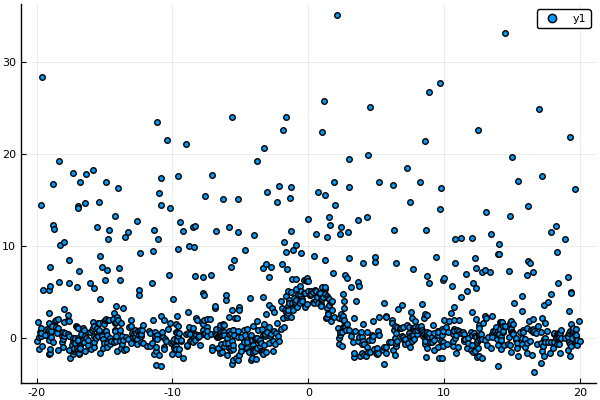

In [9]:
N = 1000
X = reshape((sort(rand(N)).-0.5).*40.0,N,1)
function latent(x)
    5.0.*sin.(x)./x
end
outliers = rand(N).>0.7
Y = (latent(X)+(1.0.-outliers).*rand(Normal(0,1),N)+abs.(outliers.*rand(Normal(0,10),N))[:]);
scatter(X,Y)

In [10]:
# Run sparse classification with increasing number of inducing points
Ms = [4, 8, 16, 32, 64]
models = Vector{AbstractGP}(undef,length(Ms)+1)
kernel = RBFKernel(1.0)
ν=10.0
for (index, num_inducing) in enumerate(Ms)
    m =  SVGP(X, Y, kernel,StudentTLikelihood(ν),AnalyticVI(),num_inducing)
    println("Training with $(num_inducing) points")
    @time train!(m,iterations=100)
    models[index] = m;
end

Training with 4 points
  0.265731 seconds (495.79 k allocations: 102.888 MiB, 15.44% gc time)
Training with 8 points
  0.619672 seconds (495.79 k allocations: 154.891 MiB, 4.97% gc time)
Training with 16 points
  0.602364 seconds (495.79 k allocations: 260.180 MiB, 8.13% gc time)
Training with 32 points
  3.147640 seconds (495.79 k allocations: 476.174 MiB, 2.69% gc time)
Training with 64 points
  0.949266 seconds (497.66 k allocations: 930.000 MiB, 10.31% gc time)


In [11]:
mfull = VGP(X, Y, kernel,StudentTLikelihood(ν),AnalyticVI())
println("Training with full model")
@time train!(mfull,iterations=5);
models[end] = mfull;

Training with full model
  5.163433 seconds (868 allocations: 463.676 MiB, 13.18% gc time)


In [12]:
function compute_Grid(model,nGrid=50)
    mins = -20
    maxs = 20
    Xplot = collect(range(mins[1],stop=maxs[1],length=nGrid))
#     Xplot = hcat([j for i in xlin, j in ylin][:],[i for i in xlin, j in ylin][:])
    y = proba_y(model,Xplot)
    return (y,Xplot)
    end;

In [13]:
function plotdata(X,Y)
    Plots.plot(X,Y,t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="",size=(300,500));
end;

In [14]:
function plotcontour(model,X,Y)
    nGrid = 100
    (predic,x) = compute_Grid(model,nGrid);
    plotdata(X,Y)
    if in(:Z,fieldnames(typeof(model)))
        plot!(model.Z[1][:,1],zero(model.Z[1][:,1]),msize=2.0,color="black",t=:scatter,lab="")
    end
    return plot!(x,predic,title=(in(:Z,fieldnames(typeof(model))) ? "M = $(model.nFeatures)" : "full"),color="red",lab="",linewidth=3.0)
end;

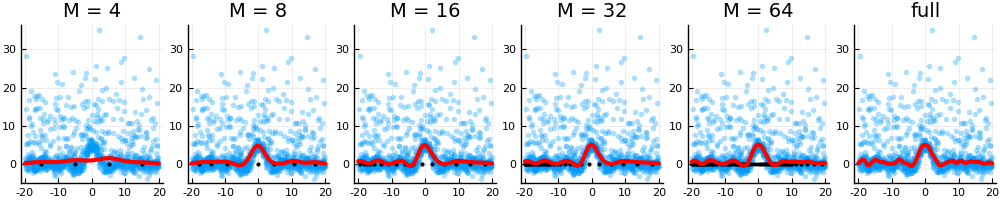

In [15]:
Plots.plot(broadcast(x->plotcontour(x,X,Y),models)...,layout=(1,length(models)),size=(1000,200))